In [57]:
import json
import folium
import datetime
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from geopandas.tools import sjoin
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

## Dealing with GeoJson

In [59]:
geo_df = gpd.read_file("data/chicago_boundaries.geojson")
geo_df.sort_values("pri_neigh").head(10)

,pri_neigh,sec_neigh,shape_area,shape_len,geometry
52,Albany Park,"NORTH PARK,ALBANY PARK",53542230.819,39339.016439,(POLYGON ((-87.70403771340104 41.9735515838182...
42,Andersonville,ANDERSONVILLE,9584592.89906,12534.092625,(POLYGON ((-87.66114249176968 41.9763032707800...
78,Archer Heights,"ARCHER HEIGHTS,WEST ELSDON",55922505.7212,31880.02103,(POLYGON ((-87.71436934735939 41.8260405636423...
8,Armour Square,"ARMOUR SQUARE,CHINATOWN",17141468.6356,24359.189625,(POLYGON ((-87.62920071904188 41.8471270613852...
21,Ashburn,ASHBURN,135460337.208,54818.154632,(POLYGON ((-87.71254775561138 41.7573373338274...
70,Auburn Gresham,AUBURN GRESHAM,105065353.602,46757.721716,(POLYGON ((-87.63990005778429 41.7561457832194...
94,Austin,AUSTIN,170037750.826,55473.345911,(POLYGON ((-87.75619515209075 41.9154695475812...
9,Avalon Park,"AVALON PARK,CALUMET HEIGHTS",34852737.7366,27630.822534,(POLYGON ((-87.58565529833413 41.7515019433031...
12,Avondale,"IRVING PARK,AVONDALE",55290595.482,34261.933404,(POLYGON ((-87.68798678784357 41.9361039411813...
93,Belmont Cragin,"BELMONT CRAGIN,HERMOSA",109099407.211,43311.706886,(POLYGON ((-87.74142999502229 41.9169848303604...


In [60]:
neighs = geo_df.pri_neigh.tolist()

In [61]:
def plot_map(geo_df, geojson_name="pri_neigh", data=None, column_name=None, map_name="map.html"):
    m = folium.Map(location=[41.8755616, -87.6244212], tiles='Mapbox Bright', zoom_start=11) ## This location is Chicago
    
    if data is None:
        folium.GeoJson(
            geo_df,
            name='geojson'
        ).add_to(m)
    else:
        bins = list(data.quantile(np.linspace(0, 1, 15))) ## to use bins, gotta check fill_color
        folium.Choropleth(
            geo_data=geo_df,
            name='choropleth',
            data=data,
            columns=[geojson_name, column_name],
            key_on='feature.properties.{}'.format(geojson_name),
            fill_color='YlGnBu',
            fill_opacity=0.7,
            line_opacity=0.2
            #bins=bins
        ).add_to(m)
        
    m.save(map_name)

In [62]:
plot_map(geo_df)

## Dealing with Food Inspections

In [63]:
inspections = pd.read_csv("data/food-inspections.csv")
inspections = inspections.dropna(subset=["Latitude", "Longitude"]) ## we drop if we do not know the location
inspections["date"] = pd.to_datetime(inspections["Inspection Date"])
inspections.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Location', 'Historical Wards 2003-2015', 'Zip Codes',
       'Community Areas', 'Census Tracts', 'Wards', 'date'],
      dtype='object')

In [64]:
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,date
0,2320315,SERENDIPITY CHILDCARE,SERENDIPITY CHILDCARE,2216009.0,Daycare Above and Under 2 Years,Risk 1 (High),1300 W 99TH ST,CHICAGO,IL,60643.0,...,NaN,41.714168,-87.655291,"{'longitude': '41.7141680989703', 'latitude': ...",NaN,NaN,NaN,NaN,NaN,2019-10-23
1,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,2589655.0,Restaurant,Risk 1 (High),1767 N MILWAUKEE AVE,CHICAGO,IL,60647.0,...,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.913588,-87.682203,"{'longitude': '41.9135877900482', 'latitude': ...",NaN,NaN,NaN,NaN,NaN,2019-10-23
2,2320328,LAS ASADAS MEXICAN GRILL,LAS ASADAS MEXICAN GRILL,2583309.0,Restaurant,Risk 1 (High),3834 W 47TH ST,CHICAGO,IL,60632.0,...,NaN,41.808025,-87.720037,"{'longitude': '41.80802515275297', 'latitude':...",NaN,NaN,NaN,NaN,NaN,2019-10-23
3,2320319,LA PALAPITA,LA PALAPITA,2694702.0,Restaurant,Risk 1 (High),3834 W 47TH ST,CHICAGO,IL,60632.0,...,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.808025,-87.720037,"{'longitude': '41.80802515275297', 'latitude':...",NaN,NaN,NaN,NaN,NaN,2019-10-23
4,2320228,47TH ST CANTINA,47TH ST CANTINA,2678250.0,Liquor,Risk 3 (Low),4311 W 47TH ST,CHICAGO,IL,60632.0,...,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.807662,-87.731480,"{'longitude': '41.80766199360051', 'latitude':...",NaN,NaN,NaN,NaN,NaN,2019-10-22


In [65]:
def get_nearest_neigh(point, geo_df):
    idx = geo_df.geometry.distance(point).idxmin()
    return geo_df.loc[idx, 'pri_neigh']

## key: key that will be used to join
def assign_neigh(geo_df, data, key, latitude="Latitude", longitude="Longitude", verbose=False):
    geometry = [Point(x, y) for x, y in zip(data[longitude], data[latitude])]
    crs = {'init': 'epsg:4326'}
    data_to_join = gpd.GeoDataFrame(data[[key, latitude, longitude]], 
                                       crs=crs,
                                       geometry=geometry)
    points_to_neigh = sjoin(data_to_join, geo_df, how='left')
    
    neigh_not_found = points_to_neigh[pd.isna(points_to_neigh.pri_neigh)]
    
    if verbose:
        print("There are {} points without an exact neighborhood".format(len(neigh_not_found)))
    
    neigh_not_found.pri_neigh = neigh_not_found.copy().geometry.apply(get_nearest_neigh, geo_df=geo_df)
    points_to_neigh.loc[neigh_not_found.index] = neigh_not_found
    
    if verbose:
        print("There are {} points without an exact neighborhood"\
              .format(len(points_to_neigh[pd.isna(points_to_neigh.pri_neigh)])))
    
    return points_to_neigh[[key, "pri_neigh", "sec_neigh"]]
    

In [66]:
inspection_location = assign_neigh(geo_df=geo_df, data=inspections, key="Inspection ID", verbose=True)

There are 2819 points without an exact neighborhood


C:\Users\Gabriel\Miniconda3\envs\ada\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


There are 0 points without an exact neighborhood


In [71]:
inspections = inspections.merge(inspection_location, on="Inspection ID")
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Community Areas,Census Tracts,Wards,date,pri_neigh_x,sec_neigh_x,pri_neigh_y,sec_neigh_y,pri_neigh,sec_neigh
0,2320315,SERENDIPITY CHILDCARE,SERENDIPITY CHILDCARE,2216009.0,Daycare Above and Under 2 Years,Risk 1 (High),1300 W 99TH ST,CHICAGO,IL,60643.0,...,NaN,NaN,NaN,2019-10-23,Washington Heights,"WASHINGTON HEIGHTS,ROSELAND",Washington Heights,"WASHINGTON HEIGHTS,ROSELAND",Washington Heights,"WASHINGTON HEIGHTS,ROSELAND"
1,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,2589655.0,Restaurant,Risk 1 (High),1767 N MILWAUKEE AVE,CHICAGO,IL,60647.0,...,NaN,NaN,NaN,2019-10-23,Wicker Park,"WICKER PARK,WEST TOWN",Wicker Park,"WICKER PARK,WEST TOWN",Wicker Park,"WICKER PARK,WEST TOWN"
2,2320328,LAS ASADAS MEXICAN GRILL,LAS ASADAS MEXICAN GRILL,2583309.0,Restaurant,Risk 1 (High),3834 W 47TH ST,CHICAGO,IL,60632.0,...,NaN,NaN,NaN,2019-10-23,Archer Heights,"ARCHER HEIGHTS,WEST ELSDON",Archer Heights,"ARCHER HEIGHTS,WEST ELSDON",Archer Heights,"ARCHER HEIGHTS,WEST ELSDON"
3,2320319,LA PALAPITA,LA PALAPITA,2694702.0,Restaurant,Risk 1 (High),3834 W 47TH ST,CHICAGO,IL,60632.0,...,NaN,NaN,NaN,2019-10-23,Archer Heights,"ARCHER HEIGHTS,WEST ELSDON",Archer Heights,"ARCHER HEIGHTS,WEST ELSDON",Archer Heights,"ARCHER HEIGHTS,WEST ELSDON"
4,2320228,47TH ST CANTINA,47TH ST CANTINA,2678250.0,Liquor,Risk 3 (Low),4311 W 47TH ST,CHICAGO,IL,60632.0,...,NaN,NaN,NaN,2019-10-22,Archer Heights,"ARCHER HEIGHTS,WEST ELSDON",Archer Heights,"ARCHER HEIGHTS,WEST ELSDON",Archer Heights,"ARCHER HEIGHTS,WEST ELSDON"


In [72]:
neigh_inspections = inspections.groupby("pri_neigh").count()["Inspection ID"]
plot_map(geo_df, data=neigh_inspections, column_name="Inspection ID", map_name="map.html")

In [73]:
inspections.Results.unique()

array(['Pass', 'Pass w/ Conditions', 'Out of Business', 'Fail',
       'No Entry', 'Not Ready', 'Business Not Located'], dtype=object)

In [74]:
def get_percentage_results(data, neigh_key="pri_neigh", results="Results", key="Inspection ID", result_type=None):
    neigh_inspections = inspections.groupby(neigh_key).count()[key]
    neigh_results = inspections.groupby([neigh_key, results]).count()[key]
    percentage_results = (neigh_results.div(neigh_inspections) * 100).reset_index()
    if result_type is None:
        return percentage_results
    else:
        return percentage_results[percentage_results.Results == result_type]

In [75]:
percentage_fail = get_percentage_results(inspections, result_type="Fail")
percentage_fail

,pri_neigh,Results,Inspection ID
0,Albany Park,Fail,19.493745
6,Andersonville,Fail,20.370370
13,Archer Heights,Fail,17.986952
19,Armour Square,Fail,19.060773
25,Ashburn,Fail,13.890596
...,...,...,...
581,West Ridge,Fail,22.913257
587,West Town,Fail,17.380509
594,Wicker Park,Fail,20.110362
600,Woodlawn,Fail,27.091255


In [76]:
plot_map(geo_df, data=percentage_fail, column_name="Inspection ID", map_name="map.html")

### Gotta analyze the different types of results. Risks can also be interesting. 
### Below the case of Subway

In [77]:
def get_inspections_restaurant(inspections, restaurant):
    return inspections[inspections["DBA Name"].str.contains(restaurant)]

### Case for subway
inspections_subway = get_inspections_restaurant(inspections, "SUBWAY")
inspections_subway

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Community Areas,Census Tracts,Wards,date,pri_neigh_x,sec_neigh_x,pri_neigh_y,sec_neigh_y,pri_neigh,sec_neigh
96,2316054,SUBWAY,SUBWAY,2590201.0,Restaurant,Risk 1 (High),2512 W NORTH AVE,CHICAGO,IL,60647.0,...,NaN,NaN,NaN,2019-10-18,Wicker Park,"WICKER PARK,WEST TOWN",Wicker Park,"WICKER PARK,WEST TOWN",Wicker Park,"WICKER PARK,WEST TOWN"
180,2315927,SUBWAY,SUBWAY,2590201.0,Restaurant,Risk 1 (High),2512 W NORTH AVE,CHICAGO,IL,60647.0,...,NaN,NaN,NaN,2019-10-16,Wicker Park,"WICKER PARK,WEST TOWN",Wicker Park,"WICKER PARK,WEST TOWN",Wicker Park,"WICKER PARK,WEST TOWN"
189,2315950,SUBWAY RESTAURANT,SUBWAY RESTAURANT,1953503.0,Restaurant,Risk 1 (High),3207 W DIVERSEY AVE,CHICAGO,IL,60647.0,...,NaN,NaN,NaN,2019-10-16,Logan Square,LOGAN SQUARE,Logan Square,LOGAN SQUARE,Logan Square,LOGAN SQUARE
283,2315770,SUBWAY,SUBWAY,2163012.0,Restaurant,Risk 1 (High),4157 W Peterson AVE,CHICAGO,IL,60646.0,...,NaN,NaN,NaN,2019-10-11,"Sauganash,Forest Glen","SAUGANASH,FOREST GLEN","Sauganash,Forest Glen","SAUGANASH,FOREST GLEN","Sauganash,Forest Glen","SAUGANASH,FOREST GLEN"
405,2315566,SUBWAY,SUBWAY,2134794.0,Restaurant,Risk 1 (High),6072-6074 N NORTHWEST HWY,CHICAGO,IL,60631.0,...,NaN,NaN,NaN,2019-10-09,Norwood Park,NORWOOD PARK,Norwood Park,NORWOOD PARK,Norwood Park,NORWOOD PARK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197650,67826,SUBWAY,SUBWAY,1979303.0,Restaurant,Risk 1 (High),4032 W 26TH ST,CHICAGO,IL,60623.0,...,NaN,NaN,NaN,2010-01-11,Little Village,LITTLE VILLAGE,Little Village,LITTLE VILLAGE,Little Village,LITTLE VILLAGE
197738,58233,SUBWAY,SUBWAY,28635.0,Restaurant,Risk 1 (High),1129 N WESTERN AVE,CHICAGO,IL,60622.0,...,NaN,NaN,NaN,2010-01-08,Ukrainian Village,UKRAINIAN VILLAGE AND EAST VILLAGE,Ukrainian Village,UKRAINIAN VILLAGE AND EAST VILLAGE,Ukrainian Village,UKRAINIAN VILLAGE AND EAST VILLAGE
197785,67787,SUBWAY STORE # 25458,SUBWAY,1492724.0,Restaurant,Risk 1 (High),1818 W MONTROSE AVE,CHICAGO,IL,60613.0,...,NaN,NaN,NaN,2010-01-07,Lincoln Square,LINCOLN SQUARE,Lincoln Square,LINCOLN SQUARE,Lincoln Square,LINCOLN SQUARE
197853,154221,SUBWAY SANDWICHES AND SALADS,SUBWAY,2013762.0,Restaurant,Risk 2 (Medium),1513 W fullerton AVE,CHICAGO,IL,60614.0,...,NaN,NaN,NaN,2010-01-06,Lincoln Park,LINCOLN PARK,Lincoln Park,LINCOLN PARK,Lincoln Park,LINCOLN PARK


In [78]:
percentage_fail_subway = get_percentage_results(inspections, result_type="Fail")
percentage_fail_subway

,pri_neigh,Results,Inspection ID
0,Albany Park,Fail,19.493745
6,Andersonville,Fail,20.370370
13,Archer Heights,Fail,17.986952
19,Armour Square,Fail,19.060773
25,Ashburn,Fail,13.890596
...,...,...,...
581,West Ridge,Fail,22.913257
587,West Town,Fail,17.380509
594,Wicker Park,Fail,20.110362
600,Woodlawn,Fail,27.091255


In [79]:
plot_map(geo_df, data=percentage_fail_subway, column_name="Inspection ID", map_name="map.html")
## There are a few areas with more fails and it seems like it is in the black part 

## Dealing with Income

In [80]:
income_df = pd.read_csv("data/Per_Capita_Income.csv")
income_df.head()

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [81]:
# Renaming the columns
income_df.columns = ['community_number','community_name','percentage_housing_crowded','percent_households_below_poverty','percent_aged_16+_unemployed','percent_aged_25+_without_highschool_diploma','percent_aged_under_18_or_over_64','per_capita_income','hardship_index']

In [82]:
# Setting the index
income_df = income_df.set_index('community_number')
income_df.head()

,community_name,percentage_housing_crowded,percent_households_below_poverty,percent_aged_16+_unemployed,percent_aged_25+_without_highschool_diploma,percent_aged_under_18_or_over_64,per_capita_income,hardship_index
community_number,,,,,,,,
1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [83]:
income_df["community_name"].unique

<bound method Series.unique of community_number
1.0         Rogers Park
2.0          West Ridge
3.0              Uptown
4.0      Lincoln Square
5.0        North Center
             ...       
74.0    Mount Greenwood
75.0        Morgan Park
76.0             O'Hare
77.0          Edgewater
NaN             CHICAGO
Name: community_name, Length: 78, dtype: object>

In [84]:
# The last row of the df corresponding to the community area name "CHICAGO" is not relevant
income_df = income_df[income_df.community_name != 'CHICAGO']

In [85]:
geo_df["pri_neigh"].unique

<bound method Series.unique of 0        Grand Boulevard
1           Printers Row
2          United Center
3     Sheffield & DePaul
4          Humboldt Park
             ...        
93        Belmont Cragin
94                Austin
95            Gold Coast
96              Boystown
97           River North
Name: pri_neigh, Length: 98, dtype: object>

### This geojson is no good because it defines the boundaries by neighbourhoods. 
### Loading the Chicago boundaries by community area to fit the income dataframe correctly.

In [87]:
geo_df_by_com = gpd.read_file("data/chicago_boundaries_community_area.geojson")
geo_df_by_com.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,(POLYGON ((-87.60914087617894 41.8446925026539...
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,(POLYGON ((-87.59215283879394 41.8169293462668...
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,(POLYGON ((-87.62879823733725 41.8018930336891...
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,(POLYGON ((-87.6067081256125 41.81681377057218...
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,(POLYGON ((-87.59215283879394 41.8169293462668...


In [88]:
np.all(geo_df_by_com["area_num_1"] == geo_df_by_com["area_numbe"])
np.all(geo_df_by_com["area"] == '0')
np.all(geo_df_by_com["perimeter"] == '0')
np.all(geo_df_by_com["comarea_id"] == '0')
np.all(geo_df_by_com["comarea"] == '0')

True

In [89]:
# Dropping the useless columns and renaming the rest
geo_df_by_com = geo_df_by_com.drop(columns=['area', 'area_num_1', 'perimeter', 'comarea_id', 'comarea'], axis=1)
geo_df_by_com.columns = ['community_name', 'shape_area', 'community_number', 'shape_len', 'geometry']
geo_df_by_com.head()

,community_name,shape_area,community_number,shape_len,geometry
0,DOUGLAS,46004621.1581,35,31027.0545098,(POLYGON ((-87.60914087617894 41.8446925026539...
1,OAKLAND,16913961.0408,36,19565.5061533,(POLYGON ((-87.59215283879394 41.8169293462668...
2,FULLER PARK,19916704.8692,37,25339.0897503,(POLYGON ((-87.62879823733725 41.8018930336891...
3,GRAND BOULEVARD,48492503.1554,38,28196.8371573,(POLYGON ((-87.6067081256125 41.81681377057218...
4,KENWOOD,29071741.9283,39,23325.1679062,(POLYGON ((-87.59215283879394 41.8169293462668...


In [90]:
geo_df_by_com["community_name"].unique

<bound method Series.unique of 0             DOUGLAS
1             OAKLAND
2         FULLER PARK
3     GRAND BOULEVARD
4             KENWOOD
           ...       
72    MOUNT GREENWOOD
73        MORGAN PARK
74              OHARE
75          EDGEWATER
76        EDISON PARK
Name: community_name, Length: 77, dtype: object>

### Merging the income df and the geojson

In [91]:
# Changing the community names to the same format as the geojson community names
income_df['community_name'] = income_df['community_name'].str.upper()

In [92]:
set(geo_df_by_com["community_name"]) - set(income_df["community_name"])

{'MONTCLARE', 'OHARE', 'WASHINGTON HEIGHTS'}

In [93]:
set(income_df["community_name"]) - set(geo_df_by_com["community_name"])

{'MONTCLAIRE', "O'HARE", 'WASHINGTON HEIGHT'}

In [94]:
income_df.loc[income_df['community_name'] == 'MONTCLAIRE', ['community_name']] = 'MONTCLARE'
income_df.loc[income_df['community_name'] == "O'HARE", ['community_name']] = 'OHARE'
income_df.loc[income_df['community_name'] == 'WASHINGTON HEIGHT', ['community_name']] = 'WASHINGTON HEIGHTS'

In [95]:
set(geo_df_by_com["community_name"]) - set(income_df["community_name"])

set()

In [96]:
set(income_df["community_name"]) - set(geo_df_by_com["community_name"])

set()

In [97]:
# Merge income df and the geojson
income_df = income_df.merge(geo_df_by_com, left_on="community_name", right_on="community_name").set_index('community_number')
income_df.head()

,community_name,percentage_housing_crowded,percent_households_below_poverty,percent_aged_16+_unemployed,percent_aged_25+_without_highschool_diploma,percent_aged_under_18_or_over_64,per_capita_income,hardship_index,shape_area,shape_len,geometry
community_number,,,,,,,,,,,
1,ROGERS PARK,7.7,23.6,8.7,18.2,27.5,23939,39.0,51259902.4506,34052.3975757,(POLYGON ((-87.65455590025104 41.9981661497025...
2,WEST RIDGE,7.8,17.2,8.8,20.8,38.5,23040,46.0,98429094.8621,43020.6894583,"(POLYGON ((-87.6846530946559 42.0194847726953,..."
3,UPTOWN,3.8,24.0,8.9,11.8,22.2,35787,20.0,65095642.7289,46972.7945549,(POLYGON ((-87.64102430213292 41.9548028055325...
4,LINCOLN SQUARE,3.4,10.9,8.2,13.4,25.5,37524,17.0,71352328.2399,36624.6030848,(POLYGON ((-87.6744075678037 41.97610340441675...
5,NORTH CENTER,0.3,7.5,5.2,4.5,26.2,57123,6.0,57054167.85,31391.6697542,(POLYGON ((-87.67336415409336 41.9323427446535...


### Plotting the map

### Can't figure out the problem here

In [99]:
plot_map(geo_df, geojson_name="community_name", data=income_df, column_name="per_capita_income", map_name="map.html")

ValueError: key_on `'properties.community_name'` not found in GeoJSON.

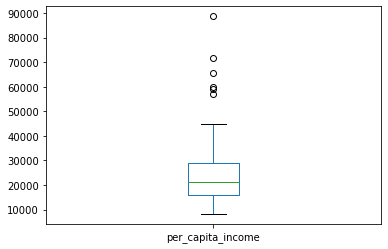

In [411]:
income_per_capita = income_df["per_capita_income"]
income_per_capita.plot.box()

### Need the map plot to be able to visualize this properly

In [414]:
income_df[income_df["per_capita_income"]>80000]

,community_name,percentage_housing_crowded,percent_households_below_poverty,percent_aged_16+_unemployed,percent_aged_25+_without_highschool_diploma,percent_aged_under_18_or_over_64,per_capita_income,hardship_index,shape_area,shape_len,geometry
community_number,,,,,,,,,,,
8,NEAR NORTH SIDE,1.9,12.9,7.0,2.5,22.6,88669,1.0,76675895.9728,57293.1649516,"MULTIPOLYGON (((-87.62446 41.91157, -87.62459 ..."


### Crime Inspection

In [ ]:
crime_df = pd.read_csv('data/Crimes_2001-2019.csv')
crime_df.head(10)
len(crime_df)

Since the dataset is 1.5gb and our Food inspection data are from 2010 and 2018 I exclude the crimes before 2010 and we can work with an easier DF.

In [ ]:
crime_df = crime_df.loc[crime_df.Year>2009]
crime_df.head(10)
len(crime_df)

In [ ]:
crime_per_year = crime_df.groupby('Year').count()
plt.plot(crime_per_year)

Is interesting to see that there is a drop of crimes in the city, we can verify if there is a drop also in the failed food inspections.

In [ ]:
crime_df = crime_df.dropna(subset=["Latitude","Longitude"])
crime_df.head(10)
len(crime_df)

In [ ]:
crime_df['Primary Type'].unique()

Some type of violation could be excluded for some resons:
- Liquor law violation is not an index of dangerous neughborhood
- Non-Criminal actions are used to code police calls that are not crimes
- Concealed carry license violation is usually found when a vehicle is in moving so we can not connect the place where is found to a neighborhood quartier

In [ ]:
test = crime_df[crime_df["Primary Type"]=="NON-CRIMINAL"]
test.head(20)

In [ ]:
crime_df = crime_df[~crime_df['Primary Type'].isin(['LIQUOR LAW VIOLATION','CONCEALED CARRY LICENSE VIOLATION','NON-CRIMINAL','NON - CRIMINAL','NON-CRIMINAL (SUBJECT SPECIFIED)'])]
crime_df.head(10)
crime_df.head(10)
len(crime_df)

We pass from 7 milion to 2.9 milions of records